Include results for Reference/Version I/Version II (we save as *_original.npy) on single layer networks

In [1]:
# 4/6/23
# KM Altenburger

# steps for downloading repo internally; run w/ "grasp_workflows kernel"
# sudo feature install ttls_fwdproxy
# mgt import --src-type pypi sdist
# mgt import --src-type pypi nvidia-cublas-cu11==11.10.3.66
# mgt import --src-type pypi ogb

import sys

sys.path.insert(0, "/home/kaltenburger/fbsource/ogb")
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ogb
import pandas as pd
import torch
#import torch_geometric
from ogb.nodeproppred import NodePropPredDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, log_loss, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split


Bad key "axes.color_cycle" on line 214 in
/home/kaltenburger/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


I0509 121113.853 _utils_internal.py:199] NCCL_DEBUG env var is set to None


I0509 121113.854 _utils_internal.py:217] NCCL_DEBUG is forced to WARN from None


### read & set-up dataset


In [2]:
dataset = NodePropPredDataset(name='ogbn-proteins')
g = dataset.graph # get edgelist and graph metadata
y = dataset.labels # outcomes
node_species_df = pd.DataFrame({'node_id':range(len(g['node_species'].flatten())), 'node_species': g['node_species'].flatten()})
node_species_df.head()

,node_id,node_species
0,0,3702
1,1,3702
2,2,3702
3,3,3702
4,4,3702


In [3]:
# create edgelist
edge_list_df = pd.DataFrame(g["edge_index"].T)
edge_list_df.columns = ['src','dst']
edge_list_df.head()

,src,dst
0,1,96401
1,96401,1
2,1,68343
3,68343,1
4,1,125069


In [4]:
# sanity check on within- vs. between-species connections
edge_list_df_check = edge_list_df.merge(node_species_df, how = 'left', left_on = 'src', right_on = 'node_id')
edge_list_df_check.drop('node_id', axis = 1, inplace=True)
edge_list_df_check = edge_list_df_check.merge(node_species_df, how = 'left', left_on = 'dst', right_on = 'node_id')
edge_list_df_check.drop('node_id', axis = 1, inplace=True)
#edge_list_df_check.head()
print(np.mean(edge_list_df_check['node_species_x']==edge_list_df_check['node_species_y']))
print(np.mean(edge_list_df_check['node_species_x']!=edge_list_df_check['node_species_y']))

0.8059610954678583


0.1940389045321417


In [5]:
# edge weights
edge_w = pd.DataFrame(g['edge_feat'])
w0 = np.mean(edge_w,1) # average edge weight
#w0 = edge_w[3]
edge_list_df['weight'] = w0
edge_list_df.head()

,src,dst,weight
0,1,96401,0.0635
1,96401,1,0.0635
2,1,68343,0.0635
3,68343,1,0.0635
4,1,125069,0.0635


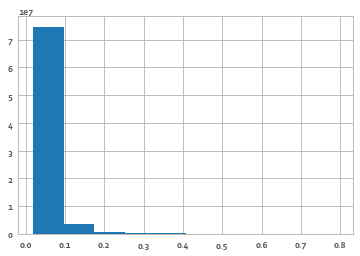

In [6]:
plt.hist(edge_list_df.weight)
plt.show()

In [8]:
# about: there are 112 prediction tasks for the ogbn-protein dataset. we split this task into 3 parts and loop through each outcome. uncomment relevant parts of code to run.
y0 = pd.DataFrame(y)
y0 = y0.iloc[:, 0:25]  # part I
#y0 = y0.iloc[:,25:50] # part II
#y0 = y0.iloc[:,50:112] # part II
y0["node_id"] = range(len(y0[0])) # index to corresponding part I-III

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = (
    split_idx["train"],
    split_idx["valid"],
    split_idx["test"],
)

X_train = y0["node_id"].iloc[train_idx]
y_train = y0.iloc[train_idx]

X_valid = y0["node_id"].iloc[valid_idx]
X_test = y0["node_id"].iloc[test_idx]
y_valid = y0.iloc[valid_idx]
y_test = y0.iloc[test_idx]

# merge in labels for training nodes on a user's connections
relevant_edges_tmp = edge_list_df.merge(
    y_train, left_on="dst", right_on="node_id", how="left"
)

In [14]:
# set-up loop
rocauc_v1_ud_w = []
rocauc_v2_ud_w = []
rocauc_ud_uw = []

for i in range(0, 25):  # part I
    # for i in range(25, 50): # part II
    # for i in range(50, 112):  # part III
    print(i)
    relevant_edges = relevant_edges_tmp[["src", "dst", "weight", "node_id", i]]
    relevant_edges.columns = ["src", "dst", "weight", "node_id", "y"]
    label1 = relevant_edges.groupby(["src"])["y"].sum().reset_index()
    labeltotal = relevant_edges.groupby(["src"])["y"].count().reset_index()
    relevant_edgelist = labeltotal.merge(label1, on="src")
    relevant_edgelist["label_0"] = relevant_edgelist["y_x"] - relevant_edgelist["y_y"]
    relevant_edgelist.rename(columns={"y_y": "label_1"}, inplace=True)
    relevant_edgelist.drop(["y_x"], axis=1, inplace=True)




    normalizer = pd.DataFrame(y_train[i].value_counts(normalize=True, ascending=True))

    # step 1 - one hop scores
    step1_one_hop_scores = pd.DataFrame(
        {
            "src": relevant_edgelist.src,
            "frac": np.log(
                (relevant_edgelist["label_1"] + 1) / (relevant_edgelist["label_0"] + 1)
            )
            * list((normalizer.iloc[0]) / (normalizer.iloc[1]))[0],
        }
    )

    # step 2 - two hop scores
    two_hop_stg = relevant_edges.merge(
        step1_one_hop_scores, left_on="dst", right_on="src", how="inner"
    )

    ## undirected, unweighted
    two_hop = two_hop_stg.groupby(["src_x"])["frac"].sum().reset_index()
    two_hop.columns = ["src", "frac"]
    two_hop_pred = two_hop.merge(X_test, left_on="src", right_on="node_id", how="right")
    pred = y_test.merge(
        two_hop_pred,
        on="node_id",
    )
    print("roc-auc, ud/uw: ", roc_auc_score(pred[i], pred["frac"]))
    rocauc_ud_uw.append(roc_auc_score(pred[i], pred["frac"]))


    ## v1 - undirected, weighted

    interval = pd.DataFrame(
        two_hop_stg.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    two_0 = (
        two_hop_stg[two_hop_stg.weight <= interval.weight[0]]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_1 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[0])
            & (two_hop_stg.weight <= interval.weight[1])
        ]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_2 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[1])
            & (two_hop_stg.weight <= interval.weight[2])
        ]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_3 = (
        two_hop_stg[(two_hop_stg.weight > interval.weight[2])]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )

    two_hop_v1 = two_0.merge(two_1, how="outer", on="src_x").fillna(0)
    two_hop_v1 = two_hop_v1.merge(two_2, how="outer", on="src_x").fillna(0)
    two_hop_v1 = two_hop_v1.merge(two_3, how="outer", on="src_x").fillna(0)
    two_hop_v1.columns = ["src_x", "frac1", "frac2", "frac3", "frac4"]
    two_hop_v1_valid = two_hop_v1.merge(
        y_valid, left_on="src_x", right_on="node_id", how="right"
    )

    clf = LogisticRegression(random_state=0).fit(
        two_hop_v1_valid[["frac1", "frac2", "frac3", "frac4"]], two_hop_v1_valid[i]
    )

    pred_v1 = y_test.merge(two_hop_v1, right_on="src_x", left_on="node_id", how="left")
    print(
        "roc-auc, v1: ",
        roc_auc_score(
            pred_v1[i],
            clf.predict_proba(pred_v1[["frac1", "frac2", "frac3", "frac4"]])[:, 1],
        ),
    )
    rocauc_v1_ud_w.append(
        roc_auc_score(
            pred_v1[i],
            clf.predict_proba(pred_v1[["frac1", "frac2", "frac3", "frac4"]])[:, 1],
        )
    )

    ## v2 undirected, weighted
    W = 4
    interval = pd.DataFrame(
        relevant_edges.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    relevant_edgelist_dict = {}
    for w in range(W):
        if w == 0:
            idx = relevant_edges.weight <= interval.weight[0]
        if w == 1:
            idx = (relevant_edges.weight > interval.weight[0]) & (
                relevant_edges.weight <= interval.weight[1]
            )
        if w == 2:
            idx = (relevant_edges.weight > interval.weight[1]) & (
                relevant_edges.weight <= interval.weight[2]
            )
        if w == 3:
            idx = relevant_edges.weight > interval.weight[2]

        label1 = (
            relevant_edges.iloc[np.where(idx)[0]]
            .groupby(["src"])["y"]
            .sum()
            .reset_index()
        )
        labeltotal = (
            relevant_edges.iloc[np.where(idx)[0]]
            .groupby(["src"])["y"]
            .count()
            .reset_index()
        )

        relevant_edgelist = labeltotal.merge(label1, on="src", how="outer").fillna(0)
        relevant_edgelist["label_0"] = (
            relevant_edgelist["y_x"] - relevant_edgelist["y_y"]
        )
        relevant_edgelist.rename(columns={"y_y": "label_1"}, inplace=True)
        relevant_edgelist.drop(["y_x"], axis=1, inplace=True)
        relevant_edgelist.columns = ["src", "label_1_" + str(w), "label_0_" + str(w)]
        relevant_edgelist_dict[w] = relevant_edgelist

    merged_edgelist = relevant_edgelist_dict[0].merge(
        relevant_edgelist_dict[1], on="src", how="outer"
    )
    merged_edgelist = merged_edgelist.merge(
        relevant_edgelist_dict[2], on="src", how="outer"
    )
    merged_edgelist = merged_edgelist.merge(
        relevant_edgelist_dict[3], on="src", how="outer"
    ).fillna(0)
    normalizer = pd.DataFrame(y_train[i].value_counts(normalize=True, ascending=True))
    step1_one_hop_scores = pd.DataFrame(
        {
            "src": merged_edgelist.src,
            "frac0": np.log(
                (merged_edgelist["label_1_0"] + 1) / (merged_edgelist["label_0_0"] + 1)
            )
            * list((normalizer.iloc[0]) / (normalizer.iloc[1]))[0],
            "frac1": np.log(
                (merged_edgelist["label_1_1"] + 1) / (merged_edgelist["label_0_1"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
            "frac2": np.log(
                (merged_edgelist["label_1_2"] + 1) / (merged_edgelist["label_0_2"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
            "frac3": np.log(
                (merged_edgelist["label_1_3"] + 1) / (merged_edgelist["label_0_3"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
        }
    )
    two_hop_stg = relevant_edges.merge(
        step1_one_hop_scores, left_on="dst", right_on="src", how="inner"
    )
    interval = pd.DataFrame(
        two_hop_stg.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    two_0 = (
        two_hop_stg[two_hop_stg.weight <= interval.weight[0]]
        .groupby(["src_x"])["frac0"]
        .sum()
        .reset_index()
    )

    two_1 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[0])
            & (two_hop_stg.weight <= interval.weight[1])
        ]
        .groupby(["src_x"])["frac1"]
        .sum()
        .reset_index()
    )

    two_2 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[1])
            & (two_hop_stg.weight <= interval.weight[2])
        ]
        .groupby(["src_x"])["frac2"]
        .sum()
        .reset_index()
    )

    two_3 = (
        two_hop_stg[(two_hop_stg.weight > interval.weight[2])]
        .groupby(["src_x"])["frac3"]
        .sum()
        .reset_index()
    )

    two_hop_v2 = two_0.merge(two_1, how="outer", on="src_x").fillna(0)
    two_hop_v2 = two_hop_v2.merge(two_2, how="outer", on="src_x").fillna(0)
    two_hop_v2 = two_hop_v2.merge(two_3, how="outer", on="src_x").fillna(0)

    two_hop_v2.columns = [
        "src_x",
        "frac0",
        "frac1",
        "frac2",
        "frac3",
    ]
    two_hop_v2_valid = two_hop_v2.merge(
        y_valid, left_on="src_x", right_on="node_id", how="right"
    )

    pred_v2 = y_test.merge(two_hop_v2, right_on="src_x", left_on="node_id", how="left")
    clf = LogisticRegression(random_state=0).fit(
        two_hop_v2_valid[
            [
                "frac0",
                "frac1",
                "frac2",
                "frac3",
            ]
        ],
        two_hop_v2_valid[i],
    )

    print(
        "roc-auc, v2: ",
        roc_auc_score(
            pred_v2[i],
            clf.predict_proba(
                pred_v2[
                    [
                        "frac0",
                        "frac1",
                        "frac2",
                        "frac3",
                    ]
                ]
            )[:, 1],
        ),
    )

    rocauc_v2_ud_w.append(
        roc_auc_score(
            pred_v2[i],
            clf.predict_proba(
                pred_v2[
                    [
                        "frac0",
                        "frac1",
                        "frac2",
                        "frac3",
                    ]
                ]
            )[:, 1],
        )
    )



    print("************************************************************************")

0


roc-auc, ud/uw:  0.5756635263681078


roc-auc, v1:  0.6422183723669541


roc-auc, v2:  0.5658765931929861
************************************************************************
1


roc-auc, ud/uw:  0.5875555063931286


roc-auc, v1:  0.6463187301853699


roc-auc, v2:  0.57506419193181
************************************************************************
2


roc-auc, ud/uw:  0.6263765117035245


roc-auc, v1:  0.6690320409028342


roc-auc, v2:  0.636885745260771
************************************************************************
3


roc-auc, ud/uw:  0.6881424867785879


roc-auc, v1:  0.7178933988064286


roc-auc, v2:  0.6890046555664098
************************************************************************
4


roc-auc, ud/uw:  0.68934773774016


roc-auc, v1:  0.7250112295036728


roc-auc, v2:  0.6970485429333156
************************************************************************
5


roc-auc, ud/uw:  0.6057115198028435


roc-auc, v1:  0.6248375412075031


roc-auc, v2:  0.6110987400156863
************************************************************************
6


roc-auc, ud/uw:  0.6734513651680474


roc-auc, v1:  0.7221502886671395


roc-auc, v2:  0.6875145617705533
************************************************************************
7


roc-auc, ud/uw:  0.6040723294432889


roc-auc, v1:  0.607824799314161


roc-auc, v2:  0.6108151929215188
************************************************************************
8


roc-auc, ud/uw:  0.6551339977321872


roc-auc, v1:  0.7213311024839038


roc-auc, v2:  0.6769622759592634
************************************************************************
9


roc-auc, ud/uw:  0.6070114195019654


roc-auc, v1:  0.6091447692607405


roc-auc, v2:  0.6776909314371496
************************************************************************
10


roc-auc, ud/uw:  0.5989126492260899


roc-auc, v1:  0.676111581262226


roc-auc, v2:  0.6447789837664756
************************************************************************
11


roc-auc, ud/uw:  0.6085430351231871


roc-auc, v1:  0.6129512070287939


roc-auc, v2:  0.6797233710101402
************************************************************************
12


roc-auc, ud/uw:  0.5107245585461103


roc-auc, v1:  0.6736042582147052


roc-auc, v2:  0.573434682678043
************************************************************************
13


roc-auc, ud/uw:  0.5865557257324359


roc-auc, v1:  0.7110317632542631


roc-auc, v2:  0.6581995022930381
************************************************************************
14


roc-auc, ud/uw:  0.5370597620903081


roc-auc, v1:  0.5673917752385536


roc-auc, v2:  0.5722934341599253
************************************************************************
15


roc-auc, ud/uw:  0.5066775753098062


roc-auc, v1:  0.620242619519718


roc-auc, v2:  0.5793715611199751
************************************************************************
16


roc-auc, ud/uw:  0.559353478318273


roc-auc, v1:  0.676220719766403


roc-auc, v2:  0.6333624766776484
************************************************************************
17


roc-auc, ud/uw:  0.6440683605463722


roc-auc, v1:  0.5081463630217142


roc-auc, v2:  0.6756557297878888
************************************************************************
18


roc-auc, ud/uw:  0.5612518323729354


roc-auc, v1:  0.6830475599536014


roc-auc, v2:  0.6367738443084239
************************************************************************
19


roc-auc, ud/uw:  0.6340760240685683


roc-auc, v1:  0.4984171097792075


roc-auc, v2:  0.6638968756131253
************************************************************************
20


roc-auc, ud/uw:  0.5066166379353961


roc-auc, v1:  0.6647351766707476


roc-auc, v2:  0.5718338068481456
************************************************************************
21


roc-auc, ud/uw:  0.5612883372517725


roc-auc, v1:  0.6828740095939501


roc-auc, v2:  0.637144975893253
************************************************************************
22


roc-auc, ud/uw:  0.5285782693911588


roc-auc, v1:  0.6353135162823348


roc-auc, v2:  0.5913252172250197
************************************************************************
23


roc-auc, ud/uw:  0.5271371715780908


roc-auc, v1:  0.6358794487920363


roc-auc, v2:  0.5899736707234119
************************************************************************
24


roc-auc, ud/uw:  0.6383480754897477


roc-auc, v1:  0.5102575049746796


roc-auc, v2:  0.6696833619314527
************************************************************************


In [15]:
print(np.mean(rocauc_ud_uw))
print(np.mean(rocauc_v1_ud_w))
print(np.mean(rocauc_v2_ud_w))

0.5928663157444838
0.6416794754420657
0.6322165170010172


In [12]:
with open('rocauc_v2_ud_w_part1_original.npy', 'wb') as f:
#with open('rocauc_v2_ud_w_part2_original.npy', 'wb') as f: # run tomorrow
#with open('rocauc_v2_ud_w_part3_original.npy', 'wb') as f:
    np.save(f, rocauc_v2_ud_w)

In [ ]:
with open("rocauc_v1_ud_w_part1.npy", "wb") as f:
    # with open('rocauc_v1_ud_w_part2.npy', 'wb') as f:
    # with open("rocauc_v1_ud_w_part3.npy", "wb") as f:
    np.save(f, rocauc_v1_ud_w)

In [149]:
with open('rocauc_ud_uw_part1.npy', 'wb') as f:
#with open('rocauc_ud_uw_part2.npy', 'wb') as f:
#with open('rocauc_ud_uw_part3.npy', 'wb') as f:
    np.save(f, rocauc_ud_uw)